<h1> Sistem Pendeteksi Situs Judi </h1>

In [1]:
import re
import csv
import json
import string

import numpy as np

import pandas as pd
import seaborn as sns

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from scipy.sparse import hstack

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import html2text
from urllib.request import Request, urlopen


<h2>Load the Data</h2>

In [2]:
file = "C:\\Users\Student\Documents\mei\dataset_judi.csv"

df = pd.read_csv(file)

df = df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df = df.dropna(axis=0)

df.head()

,category,content
0,judi,Selamat Datang Di Prediksi Togel Hongkong Terh...
1,judi,prediksitogeljuaraâs diaryPrediksi Togel Hon...
2,judi,Top Situs Agen Judi Poker QQ Domino 99 BandarQ...
3,judi,TOGELHOKI BANDAR TOGEL ONLINEbandar togel\r\nb...
4,judi,"GoldTogel4D - Agen Togel Online Terbaik, Terbe..."


In [3]:
df['judi'] = df['category'].map( {'judi':1, 'whitelist':0} ).astype(int)

In [4]:
df.head()

,category,content,judi
0,judi,Selamat Datang Di Prediksi Togel Hongkong Terh...,1
1,judi,prediksitogeljuaraâs diaryPrediksi Togel Hon...,1
2,judi,Top Situs Agen Judi Poker QQ Domino 99 BandarQ...,1
3,judi,TOGELHOKI BANDAR TOGEL ONLINEbandar togel\r\nb...,1
4,judi,"GoldTogel4D - Agen Togel Online Terbaik, Terbe...",1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1641 entries, 0 to 1640
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  1641 non-null   object
 1   content   1641 non-null   object
 2   judi      1641 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 44.9+ KB


In [6]:
df.groupby('category').describe()

judi                                   
            count mean  std  min  25%  50%  75%  max
category                                            
judi       1265.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
whitelist   376.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

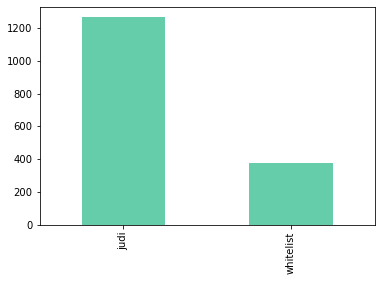

In [7]:
df.category.value_counts().plot.bar(color='MediumAquamarine');

<h3>Wordclouds</h3>

In [8]:
df_judi = df[df['judi'] == 1].copy()
df_whitelist = df[df['judi'] == 0].copy()

In [9]:
def show_wordcloud(data, title):
    text = ' '.join(data['content'].astype(str).tolist())
    stops = stopwords.words('indonesian')
    fig_wordcloud = WordCloud(stopwords=stops, background_color='white', 
                              colormap='viridis', width=800, 
                              height=600).generate(text)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()
    

<h4>Wordcloud of Judi Content</h4>

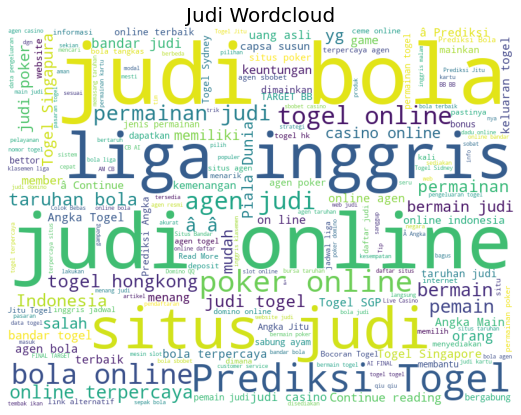

In [10]:
show_wordcloud(df_judi, "Judi Wordcloud")

<h4>Wordcloud of Whitelist Content</h4>

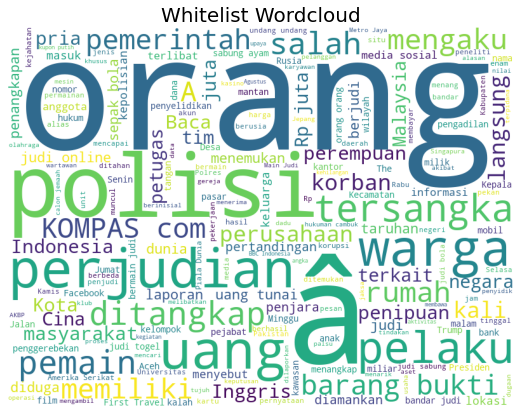

In [11]:
show_wordcloud(df_whitelist, "Whitelist Wordcloud")

<h2>Text Preprocessing</h2>

In [12]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [13]:
stops = stopwords.words('indonesian')
stops.append('yg')
#stops

In [14]:
def process(text):
    text = [c for c in text if c not in string.punctuation]
    text = ''.join(text).split()
    
    text = \
        [word.lower() for word in text if word.lower() not in stops]
    
    return text

<h4>Top 20 words in Judi content</h4>

In [15]:
df_judi.loc[:, 'content'] = df_judi['content'].apply(process)
words_df_judi = df_judi['content'].tolist()

list_judi_words = []
for sublist in words_df_judi:
    for item in sublist:
        list_judi_words.append(item)
        
c_judi = Counter(list_judi_words)
df_judi_top20 = pd.DataFrame(c_judi.most_common(20),columns=['word','count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'judi'),
  Text(1, 0, 'online'),
  Text(2, 0, 'togel'),
  Text(3, 0, 'bola'),
  Text(4, 0, 'permainan'),
  Text(5, 0, 'agen'),
  Text(6, 0, 'situs'),
  Text(7, 0, 'prediksi'),
  Text(8, 0, 'poker'),
  Text(9, 0, 'taruhan'),
  Text(10, 0, 'terpercaya'),
  Text(11, 0, 'bermain'),
  Text(12, 0, 'bandar'),
  Text(13, 0, 'angka'),
  Text(14, 0, 'liga'),
  Text(15, 0, 'inggris'),
  Text(16, 0, 'indonesia'),
  Text(17, 0, 'casino'),
  Text(18, 0, 'sbobet'),
  Text(19, 0, 'pemain')])

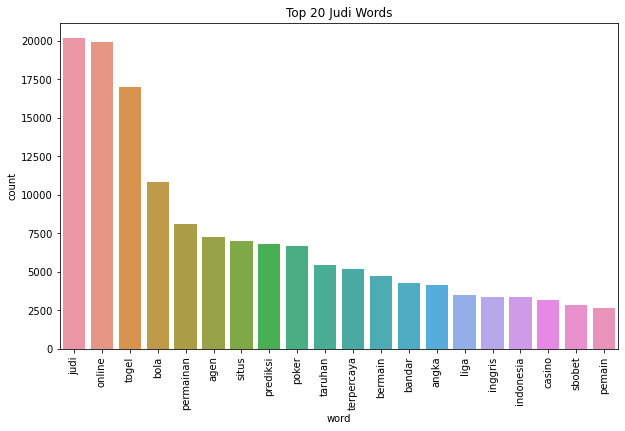

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='word', y='count',
            data=df_judi_top20, ax=ax)

plt.title("Top 20 Judi Words")
plt.xticks(rotation='vertical')

<h4>Top 20 words in Whitelist content</h4>

In [17]:
df_whitelist.loc[:, 'content'] = df_whitelist['content'].apply(process)
words_df_whitelist = df_whitelist['content'].tolist()

list_whitelist_words = []
for sublist in words_df_whitelist:
    for item in sublist:
        list_whitelist_words.append(item)
                
c_whitelist = Counter(list_whitelist_words)
df_wl_top20 = pd.DataFrame(c_whitelist.most_common(20),columns=['word','count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'judi'),
  Text(1, 0, 'orang'),
  Text(2, 0, 'polisi'),
  Text(3, 0, 'uang'),
  Text(4, 0, 'perjudian'),
  Text(5, 0, 'warga'),
  Text(6, 0, 'juta'),
  Text(7, 0, 'pelaku'),
  Text(8, 0, 'rp'),
  Text(9, 0, 'rumah'),
  Text(10, 0, 'ditangkap'),
  Text(11, 0, 'tersangka'),
  Text(12, 0, 'pemain'),
  Text(13, 0, 'kota'),
  Text(14, 0, 'salah'),
  Text(15, 0, 'bola'),
  Text(16, 0, 'dunia'),
  Text(17, 0, 'bukti'),
  Text(18, 0, 'barang'),
  Text(19, 0, 'indonesia')])

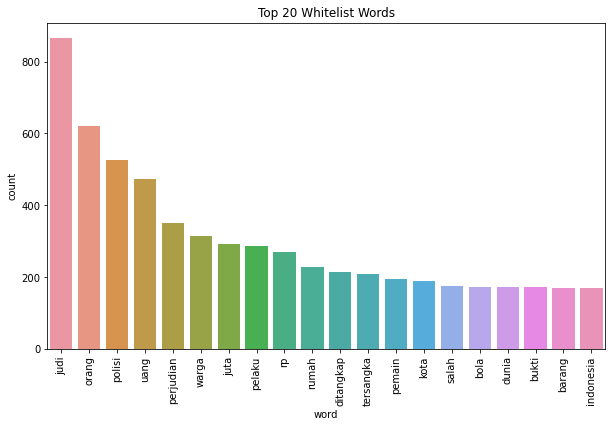

In [18]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='word', y='count',
            data=df_wl_top20, ax=ax)

plt.title("Top 20 Whitelist Words")
plt.xticks(rotation='vertical')

<h2>Extract the Features</h2>

In [19]:
bow_transformer = CountVectorizer(analyzer=process).fit(df['content'])

In [20]:
vocab_len = len(bow_transformer.vocabulary_)
print('There are ', vocab_len, ' different words in all data content')

There are  31606  different words in all data content


In [21]:
bow_transformer.vocabulary_

{'selamat': 25893,
 'prediksi': 23598,
 'togel': 29261,
 'hongkong': 11803,
 'terheboh': 28476,
 'disiniuntuk': 9102,
 'memenangkan': 17612,
 'taruhan': 27934,
 'online': 20873,
 'dipelajari': 8783,
 'data': 7626,
 'akurat': 3257,
 'apapun': 3720,
 'bertanding': 5624,
 'menang': 17915,
 'berhasil': 5125,
 'â\x80\x93': 31210,
 'hk': 11715,
 'inipun': 12454,
 'berlaku': 5331,
 'singapore': 26613,
 'membandingkan': 17403,
 'malam': 16583,
 'angka': 3603,
 'memperhatikan': 17745,
 'agen': 3037,
 'pilihan': 23130,
 'situlah': 26748,
 'kesempatan': 14630,
 'emas': 9843,
 'peluang': 21693,
 'hadiah': 11282,
 'dibandingkan': 8078,
 'mencari': 18004,
 'situs': 26750,
 'judi': 13217,
 'dewa': 7914,
 'fasilitasnya': 10202,
 'membernya': 17507,
 'proses': 23808,
 'pemasangan': 21738,
 'pahami': 21211,
 'terkait': 28544,
 'prediksitogelhongkong': 23619,
 'memprediksi': 17800,
 'main': 16484,
 'dikeluarkan': 8501,
 'mesin': 19569,
 'kesulitan': 14681,
 'kemenangan': 14321,
 'perhatikan': 22658,
 'se

In [22]:
bow_data = bow_transformer.transform(df['content'])

In [23]:
bow_data.shape

(1641, 31606)

<h2>Train the Classifier</h2>

<h4>Perform train-test split</h4>

In [24]:
content_train, content_test, label_train, label_test = \
    train_test_split(df['content'], df['judi'], test_size=0.2, random_state=5)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(content_train.shape[0]))
print('Number of rows in the test set: {}'.format(content_test.shape[0]))

Number of rows in the total set: 1641
Number of rows in the training set: 1312
Number of rows in the test set: 329


In [25]:
#content_train

<h2>Apply the Classifiers</h2>

<h3>Unigram - Naive Bayes Classifier Pipeline</h3>

In [26]:
pipe_MNB = Pipeline([
    ('bow', CountVectorizer(analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf_MNB', MultinomialNB())
])

pipe_MNB.fit(X=content_train, y=label_train)
pred_test_MNB = pipe_MNB.predict(content_test)

acc_MNB = accuracy_score(label_test, pred_test_MNB)

print(acc_MNB)
print(pipe_MNB.score(content_test, label_test))

0.9361702127659575
0.9361702127659575


<h4>Check for wrong predictions (whitelist predicted as judi)</h4>

In [27]:
count1 = 0 
for i in range(len(label_test)):
    if label_test.iloc[i] != pred_test_MNB[i]:
        count1 +=1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count1)

Total number of cases:  329
Number of wrong prediction:  21


In [28]:
content_test[label_test != pred_test_MNB]

184     Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
580     Pelajaran (atau belajar) dari penipu terbesar ...
1135    Calon haji RI berpaspor Filipina korban penipu...
1514    550 Operator Judi Akan Dipantau Selama Piala A...
688     Akankah penghargaan Oscar 2019 melahirkan bint...
1463    Berkilah Butuh Biaya Sekolah, Ibu ini Jadi Ban...
653     Wajah pertokoan di Inggris berubahKabar baik m...
176     Praktik Judi "Jakpot" dan "Topskor" di Mangga ...
258     Perjudian Nissan di Segmen "Pembelian Borongan...
1312    Jenderal Iran peringatkan Trump, jika diserang...
870     Shakespeare akan diajarkan di tingkat SDAnak-a...
253     Bagikan Kartu Bonus Judi Poker, Supermarket Ra...
628     Judi maya 'semakin marak'Aplikasi permainan ju...
1565    Saingi Makau, Australia Bangun Surga Perjudian...
386     Kecanduan Judi "Online", Bocah di Inggris Habi...
931     Facebook rilis aplikasi judi dengan uang asliA...
798     Mengapa Jepang ingin turunkan usia dewasa dari...
908     Konsum

In [29]:
def detect_judi_uni(j):
    return pipe_MNB.predict([j])[0]

detect_judi_uni(df['content'][8])

0

In [30]:
df['category'][8]

'whitelist'

<h3>Unigram - Support Vector Machine Classifier Pipeline</h3>

In [31]:
pipe_SVM = Pipeline ([
    ('bow', CountVectorizer(analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

pipe_SVM.fit(X=content_train, y=label_train)
pred_test_SVM = pipe_SVM.predict(content_test)

acc_SVM = accuracy_score(label_test, pred_test_SVM)

print(acc_SVM)
print(pipe_SVM.score(content_test, label_test))

0.9969604863221885
0.9969604863221885


<h4>Check for wrong predictions (whitelist predicted as judi)</h4>

In [32]:
count_svm = 0 
for i in range(len(label_test)):
    if label_test.iloc[i] != pred_test_SVM[i]:
        count_svm +=1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count_svm)

Total number of cases:  329
Number of wrong prediction:  1


In [33]:
content_test[label_test != pred_test_SVM]

184    Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
Name: content, dtype: object

In [34]:
def detect_judi_svm(j):
    return pipe_SVM.predict([j])[0]

detect_judi_svm(df['content'][9])

0

In [35]:
df['category'][9]

'whitelist'

<h2>Evaluate the Model</h2>

<h3>Accuracy_score</h3>

<p>classification accuracy = correct predictions / total predictions <br>(TP + TN) / (TP + TN + FP + FN)</p>

In [36]:
list_clf = ['MNB', 'SVM']

list_pred = [pred_test_MNB, pred_test_SVM]

dict_pred = dict(zip(list_clf, list_pred))

In [37]:
dict_acc = {}
for clf in list_clf:
    dict_acc[clf] = accuracy_score(label_test, dict_pred[clf])

In [38]:
for clf in list_clf:
    print(clf, " ", dict_acc[clf])

MNB   0.9361702127659575
SVM   0.9969604863221885


<h3>Precision_score</h3>

<p>Precision is intuitively the ability of the classifier not to label as positive a sample that is negative<br>TP / (TP + FP)</p>

In [39]:
#measuring precision score for each label (judi, whitelist)
for clf in list_clf:
    print(clf, " ", precision_score(label_test, dict_pred[clf], average=None, labels=[1,0]))

MNB   [0.92134831 1.        ]
SVM   [0.99595142 1.        ]


<h3>Recall_score</h3>

<p>Recall is intuitively the ability of the classifier to find all the positive samples <br>TP / (TP + FN)</p>

In [40]:
for clf in list_clf:
    print(clf, " ", recall_score(label_test, dict_pred[clf], average=None, labels=[1,0]))

MNB   [1.         0.74698795]
SVM   [1.         0.98795181]


<h3>F1_score</h3>

<p>The F-beta score can be interpreted as a weighted harmonic between mean of the precision and recall. The best score is 1 and worst is 0.</p>

In [41]:
for clf in list_clf:
    print(clf, " ", f1_score(label_test, dict_pred[clf],  average=None, labels=[1,0]))

MNB   [0.95906433 0.85517241]
SVM   [0.9979716  0.99393939]


<h3>Classification_report</h3>

<h4>Classification report for Unigram - MultinomialNB</h4>

In [42]:
print(classification_report(label_test, pred_test_MNB))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        83
           1       0.92      1.00      0.96       246

    accuracy                           0.94       329
   macro avg       0.96      0.87      0.91       329
weighted avg       0.94      0.94      0.93       329



<h4>Classification report for Support Vector Machine</h4>

In [43]:
print(classification_report(label_test, pred_test_SVM))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        83
           1       1.00      1.00      1.00       246

    accuracy                           1.00       329
   macro avg       1.00      0.99      1.00       329
weighted avg       1.00      1.00      1.00       329



<h3>Extract Bigram Features [Ngram_range = (2,2) ]</h3>

In [44]:
def process1(text):
    text = text.lower()
    text = re.sub('[^a-zA-z\s]', '', text)
    text = re.sub('_', '', text)
    return text

text = df['content'].apply(process1)

for i, line in enumerate(text):
    text[i] = ' '.join([word for word in nltk.word_tokenize(line) if word not in stops])
    
text.head()

0    selamat prediksi togel hongkong terheboh disin...
1    prediksitogeljuaras diaryprediksi togel hongko...
2    top situs agen judi poker qq domino bandarq on...
3    togelhoki bandar togel onlinebandar togel band...
4    goldtogeld agen togel online terbaik terbesar ...
Name: content, dtype: object

In [45]:
# Getting bigrams  
vect2 = CountVectorizer(ngram_range = (2,2)) 
X2 = vect2.fit_transform(text)  
features2 = (vect2.get_feature_names())

# Replacing spaces with '_' in every Bigram
features2nu = []
for c in features2:
    feature = str.replace(c, ' ', '_')
    features2nu.append(feature)
    
#print("Features : \n", features2) 

In [46]:
# Getting top ranking features 
sums = X2.sum(axis = 0)

data2 = [] 
for col, term in enumerate(features2nu): 
    data2.append((term, sums[0,col] )) 

words2 = pd.DataFrame(data2, columns = ['term','rank']) 
ranking2 = (words2.sort_values('rank', ascending = False)) 

#print("X2 : \n", X2.toarray()) 
print ("Words head : \n", ranking2.head(20))

Words head : 
                      term  rank
64516           judi_bola  5518
65158         judi_online  5228
84727        liga_inggris  3274
141399     prediksi_togel  2742
160400         situs_judi  2650
178613       togel_online  2556
23726         bola_online  2528
138913       poker_online  2451
1299            agen_judi  2341
133951     permainan_judi  2001
118942  online_terpercaya  1958
178230     togel_hongkong  1647
167306       taruhan_bola  1608
65558          judi_togel  1454
17841        bermain_judi  1221
65311          judi_poker  1217
178842    togel_singapura  1190
27445       casino_online  1121
137092        piala_dunia  1095
117546        online_judi   976


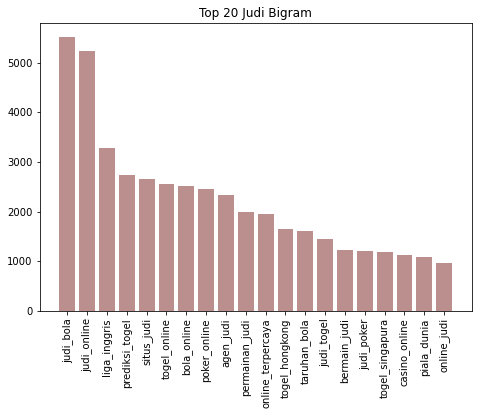

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ranking2['term'][:20], ranking2['rank'][:20], color='RosyBrown')

plt.title("Top 20 Judi Bigram")
plt.xticks(rotation='vertical')
plt.show()


In [48]:
def show_wordcloud1(data, title):
    fig_wordcloud = WordCloud(stopwords=stops, background_color='white', 
                              colormap='cividis', width=800, 
                              height=600).generate(data)
    
    plt.figure(figsize=(10,7), frameon=True)
    plt.imshow(fig_wordcloud)
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()
    

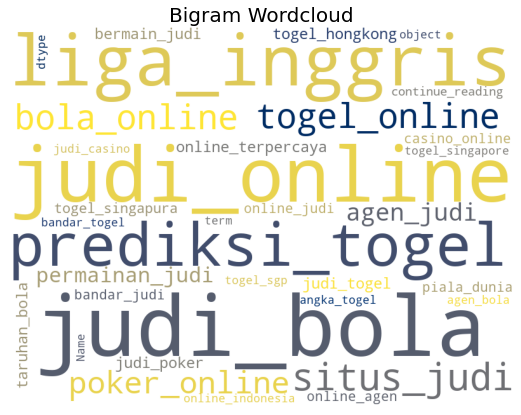

In [49]:
show_wordcloud1(str(ranking2['term'][:30]), "Bigram Wordcloud")

<h3>Bigram - NB Classifier Pipeline</h3>

In [50]:
judi_filter2 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2), analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

judi_filter2.fit(content_train, label_train)
predict2 = judi_filter2.predict(content_test)

count2 = 0 
for i in range(len(label_test)):
    if label_test.iloc[i] != predict2[i]:
        count2 +=1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count2)

Total number of cases:  329
Number of wrong prediction:  21


In [51]:
content_test[label_test != predict2]

184     Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
580     Pelajaran (atau belajar) dari penipu terbesar ...
1135    Calon haji RI berpaspor Filipina korban penipu...
1514    550 Operator Judi Akan Dipantau Selama Piala A...
688     Akankah penghargaan Oscar 2019 melahirkan bint...
1463    Berkilah Butuh Biaya Sekolah, Ibu ini Jadi Ban...
653     Wajah pertokoan di Inggris berubahKabar baik m...
176     Praktik Judi "Jakpot" dan "Topskor" di Mangga ...
258     Perjudian Nissan di Segmen "Pembelian Borongan...
1312    Jenderal Iran peringatkan Trump, jika diserang...
870     Shakespeare akan diajarkan di tingkat SDAnak-a...
253     Bagikan Kartu Bonus Judi Poker, Supermarket Ra...
628     Judi maya 'semakin marak'Aplikasi permainan ju...
1565    Saingi Makau, Australia Bangun Surga Perjudian...
386     Kecanduan Judi "Online", Bocah di Inggris Habi...
931     Facebook rilis aplikasi judi dengan uang asliA...
798     Mengapa Jepang ingin turunkan usia dewasa dari...
908     Konsum

In [52]:
def detect_judi_bi(j):
    return judi_filter2.predict([j])[0]

In [53]:
detect_judi_bi(df['content'][6])

1

In [54]:
df['category'][6]

'judi'

<h4>Classification report for Bigram - MultinomialNB</h4>

In [55]:
print(classification_report(predict2, label_test))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        62
           1       1.00      0.92      0.96       267

    accuracy                           0.94       329
   macro avg       0.87      0.96      0.91       329
weighted avg       0.95      0.94      0.94       329



<h3>Bigram - SVM Classifier Pipeline</h3>

In [56]:
from sklearn.svm import SVC

judi_filter2_svm = Pipeline([
    ('vect', CountVectorizer(ngram_range=(2,2), analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

judi_filter2_svm.fit(content_train, label_train)
predict2_svm = judi_filter2_svm.predict(content_test)

count2_svm = 0 
for i in range(len(label_test)):
    if label_test.iloc[i] != predict2_svm[i]:
        count2_svm +=1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count2_svm)

Total number of cases:  329
Number of wrong prediction:  1


In [57]:
content_test[label_test != predict2_svm]

184    Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
Name: content, dtype: object

In [58]:
def detect_judi_bi_svm(j):
    return judi_filter2.predict([j])[0]

In [59]:
detect_judi_bi_svm(df['content'][4])

1

In [60]:
df['judi'][4]

1

<h4>Classification report for Bigram - SVM</h4>

In [61]:
print(classification_report(predict2_svm, label_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        82
           1       1.00      1.00      1.00       247

    accuracy                           1.00       329
   macro avg       0.99      1.00      1.00       329
weighted avg       1.00      1.00      1.00       329



<h3>Extract Trigram Features [ Ngram_range = (3,3) ]</h3>

In [62]:
# Getting trigrams  
vect3 = CountVectorizer(ngram_range = (3,3)) 
X4 = vect3.fit_transform(text)
features3 = (vect3.get_feature_names())

features3nu = []
for c in features3:
    feature = str.replace(c, ' ', '_')
    features3nu.append(feature)

#print("Features : \n", features3nu)

In [63]:
# Getting top ranking features
sums = X4.sum(axis = 0) 

data3 = []
for col, term in enumerate(features3nu): 
    data3.append( (term, sums[0,col]))

words3 = pd.DataFrame(data3, columns = ['term','rank']) 
ranking3 = (words3.sort_values('rank', ascending = False))

# print("X4 : \n", X4.toarray())
print ("Words head : \n", ranking3.head(10)) 

Words head : 
                          term  rank
92652        judi_bola_online  1719
237612        situs_judi_bola   936
237683      situs_judi_online   846
1964           agen_judi_bola   800
196304  permainan_judi_online   755
96970       judi_togel_online   667
2017         agen_judi_online   581
96027       judi_poker_online   546
122706    liga_inggris_jadwal   490
87880     jadwal_liga_inggris   455


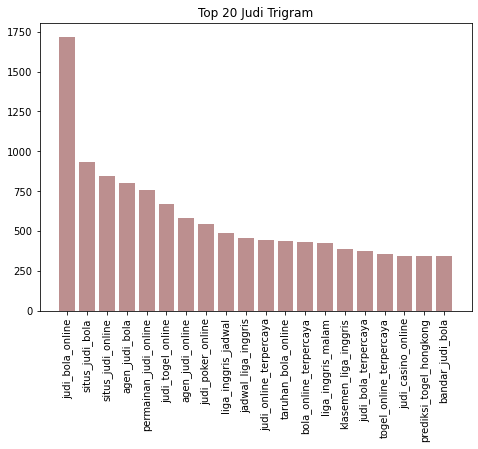

In [64]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ranking3['term'][:20], ranking3['rank'][:20], color='RosyBrown')

plt.title("Top 20 Judi Trigram")
plt.xticks(rotation='vertical')
plt.show()

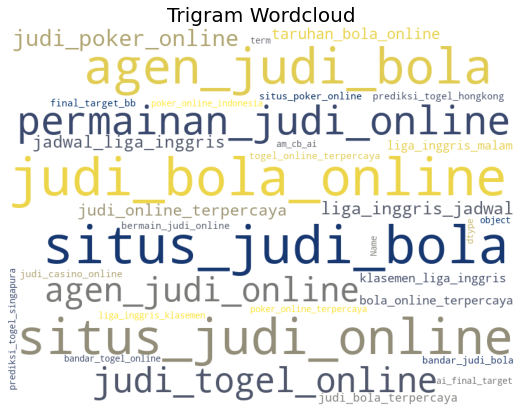

In [65]:
show_wordcloud1(str(ranking3['term'][:30]), "Trigram Wordcloud")

<h3>Trigram - NB Classifier Pipeline</h3>

In [66]:
judi_filter3 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,3), analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

judi_filter3.fit(content_train, label_train)
predict3 = judi_filter3.predict(content_test)

count3 = 0
for i in range(len(label_test)):
    if label_test.iloc[i] != predict3[i]:
        count3 += 1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count3)

Total number of cases:  329
Number of wrong prediction:  21


In [67]:
content_test[label_test != predict3]

184     Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
580     Pelajaran (atau belajar) dari penipu terbesar ...
1135    Calon haji RI berpaspor Filipina korban penipu...
1514    550 Operator Judi Akan Dipantau Selama Piala A...
688     Akankah penghargaan Oscar 2019 melahirkan bint...
1463    Berkilah Butuh Biaya Sekolah, Ibu ini Jadi Ban...
653     Wajah pertokoan di Inggris berubahKabar baik m...
176     Praktik Judi "Jakpot" dan "Topskor" di Mangga ...
258     Perjudian Nissan di Segmen "Pembelian Borongan...
1312    Jenderal Iran peringatkan Trump, jika diserang...
870     Shakespeare akan diajarkan di tingkat SDAnak-a...
253     Bagikan Kartu Bonus Judi Poker, Supermarket Ra...
628     Judi maya 'semakin marak'Aplikasi permainan ju...
1565    Saingi Makau, Australia Bangun Surga Perjudian...
386     Kecanduan Judi "Online", Bocah di Inggris Habi...
931     Facebook rilis aplikasi judi dengan uang asliA...
798     Mengapa Jepang ingin turunkan usia dewasa dari...
908     Konsum

In [68]:
def detect_judi_tri(j):
    return judi_filter3.predict([j])[0]


In [69]:
detect_judi_tri(df['content'][111])

1

In [70]:
df['category'][111]

'judi'

In [71]:
print(classification_report(predict3, label_test))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        62
           1       1.00      0.92      0.96       267

    accuracy                           0.94       329
   macro avg       0.87      0.96      0.91       329
weighted avg       0.95      0.94      0.94       329



<h3>Trigram - SVM Classifier Pipeline</h3>

In [72]:
judi_filter3_svm = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3,3), analyzer=process)),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

judi_filter3_svm.fit(content_train, label_train)
predict3_svm = judi_filter3_svm.predict(content_test)

count3_svm = 0 
for i in range(len(label_test)):
    if label_test.iloc[i] != predict3_svm[i]:
        count3_svm +=1
        
print('Total number of cases: ', len(label_test))
print('Number of wrong prediction: ', count3_svm)

Total number of cases:  329
Number of wrong prediction:  1


In [73]:
content_test[label_test != predict3_svm]

184    Perjudian Gattuso Saat AC Milan Hadapi Sassuol...
Name: content, dtype: object

In [74]:
def detect_judi_tri_svm(j):
    return judi_filter3.predict([j])[0]

In [75]:
detect_judi_tri_svm(df['content'][9])

0

In [76]:
df['category'][9]

'whitelist'

<h4>Classification report for Trigram - SVM</h4>

In [109]:
print(classification_report(predict3_svm, label_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        82
           1       1.00      1.00      1.00       247

    accuracy                           1.00       329
   macro avg       0.99      1.00      1.00       329
weighted avg       1.00      1.00      1.00       329



<h2>Test the Program</h2>

<h4>Get Website Content</h4>

In [85]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [101]:
url = "https://regional.kompas.com/read/2021/03/29/193909478/korupsi-dana-nasabah-rp-21-m-untuk-judi-bola-mantan-pegawai-bank-divonis-65"
#url = "https://id.wikipedia.org/wiki/Perjudian"
#url = "https://rottenbroadway.com/"
req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})

web_byte = urlopen(req).read()
webpage = web_byte.decode('utf-8')

print(webpage)

<!DOCTYPE html>
<html lang="en">
<head>
       
<!-- Google Tag Manager -->
<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':
new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagName(s)[0],
j=d.createElement(s),dl=l!='dataLayer'?'&l='+l:'';j.async=true;j.src=
'https://www.googletagmanager.com/gtm.js?id='+i+dl;f.parentNode.insertBefore(j,f);
})(window,document,'script','dataLayer','GTM-PT7PC4');</script>
<!-- End Google Tag Manager -->
<title>Korupsi Dana Nasabah Rp 2,1 M untuk Judi Bola, Mantan Pegawai Bank Divonis 6,5 Tahun Penjara</title>
<link href="//securepubads.g.doubleclick.net" rel="dns-prefetch">
<link href="//asset.kompas.com" rel="dns-prefetch">
<link href="//adsimg.kompas.com" rel="dns-prefetch">
<link href="//static.criteo.net" rel="dns-prefetch">
<link href="//bidder.criteo.com" rel="dns-prefetch">
<link href="//rtax.criteo.com" rel="dns-prefetch">
<link href="//tpc.googlesyndication.com" rel="dns-prefetch">
<link href="//cm.g.doubleclick.net" r

<h4>Get Rid of the HTML Tags</h4>

In [102]:
h = html2text.HTML2Text()
h.ignore_links = True

h_clean = h.handle(webpage)

print(h_clean)

  * Harian Kompas
  * Kompas TV
  * Live Radio

  * Kompasiana.com
  * Kompaskarier.com
  * Gramedia.com
  * Gramedia Digital
  * GridOto.com
  * Bolasport.com
  * Grid.id
  * Kontan.co.id
  * Kgmedia.id

![25 Tahun Kompas.com, Melihat
Harapan](https://asset.kompas.com/data/2017/wp/images/ultah/logo-
kompascom-25th@2x.png)

Langganan Kompas.id

  * MASUK

  * News
    * Nasional
    * Megapolitan
    * Global
    * Surat Pembaca
    * Kilas Daerah
    * Kilas Korporasi
    * Kilas Kementerian
    * Sorot Politik
    * Kilas Badan Negara
    * Kilas Parlemen
    * Indeks
    * Regional
      * Medan
      * Palembang
      * Surabaya
      * Makassar
      * Balikpapan
      * Samarinda
  * Tren
  * Health
  * Food
    * Resep
    * Tips Kuliner
    * Food News
    * Food Story
    * Galeri
  * Edukasi
    * Sekolah
    * Perguruan Tinggi
    * Pendidikan Khusus
    * Beasiswa
    * Skola
    * Dunia Kuliah
    * Kilas Pendidikan
  * Parapuan
    * Trending Topic
    * Love & Life
    *

<h4>Predict the Web Content</h4>

In [103]:
detect_judi_uni(h_clean)

0

In [104]:
detect_judi_bi(h_clean)

0

In [105]:
detect_judi_tri(h_clean)

0

In [106]:
detect_judi_svm(h_clean)

0

In [107]:
detect_judi_bi_svm(h_clean)

0

In [108]:
detect_judi_tri_svm(h_clean)

0